In [44]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns

In [45]:
sns.set_style('darkgrid')
sns.set(rc={'figure.figsize': (12,6)})

# Modelling a Stock Market Exhibiting Inertia

### Expected perceived value

The *expected perceived value* (EPV) of an asset models the asset's *intrinsic value* in a hypothetical and perfectly efficient market. While the latter is not measurable, the former certainly provides a good estimate as it represents the value you would get after averaging over a very large number of interviews with traders. 

Expressly, we define the *expected perceived value* of an equity by:

$$
\psi(t) = \psi_0 e^{\frac{t}{T} \nu \cdot (1+\phi(t))}
$$

where t is the time measured in days from the beginning of the experiment, $\Psi_0$ is the initial *expected perceived value* (EPV), $\nu$ is the growth exponent defined with the help of the expected compound annual growth rate $\mathbb{E}(cagr)$ in the absence of any influential sentiment. $T$ is the duration of the trading period after which the EPV has been reached.

$$
\nu = ln(1+\mathbb{E}(cagr))
$$ 

Now, we model $\phi(t): \mathbb{N}^+ \rightarrow [-\infty, 1]$ as a piece-wise linear, (potentially) non-continuous function over time, representing the sentiment of the trading community with regards to the given asset. A positive sentiment thus has a direct influence on the expected perceived value of the asset.

A neutral sentiment of $\phi(t)=0$ over the entire period would mean that it is maximum likely to meet its expected $cagr$. Obviously, a negative sentiment will cause the stock value to decline over time. We allow it do decline arbitrarily rapidly by allowing $\phi$ to yield very large negative values. A sudden change in the sentiment, thus, explicitly leads to a sudden plunge or surge in the expected perceived value EPV. With those sudden changes we can model earnings surprises or any unexpected good or bad news.

In our playground, a year has four equally long quarters of 64 business days each. That's close to a real-world year and good for GPU performance. 


### Modelling sectors and geo-markets

Not only stocks but also market segments or even entire markets are influenced by sentiment. That's being covered by our ```GeoMarket``` and ```Segment``` classes.

In [3]:
from markets.dynamic_market import Segment, GeoMarket, Stock

#### Piece-wise linear functions for segment and geo-market sentiment

In [38]:
it = Segment(name="Information Technology", sentiments={
    0: (0.1, 2e-3),
    64: (.3, 0),
    128: (.25, -1e-3),
    192: (.1, 1e-3)
})

us = GeoMarket(name="United States", sentiments={
    0: (0.1, 0),
    128: (.25, 1e-3)
})
europe = GeoMarket(name="Europe", sentiments={
    0: (0.1, -1e-3),
    192: (-.025, 5e-4)
})

Here's what the IT sector's und US market's sentiment looks like over the year. We model positive and negative earnings surprises and some slowly changing sentiment over time between the earnings calls. In the US market case that may be some news about the impeachment process.

In [39]:
from utils.chartutils import plot_many

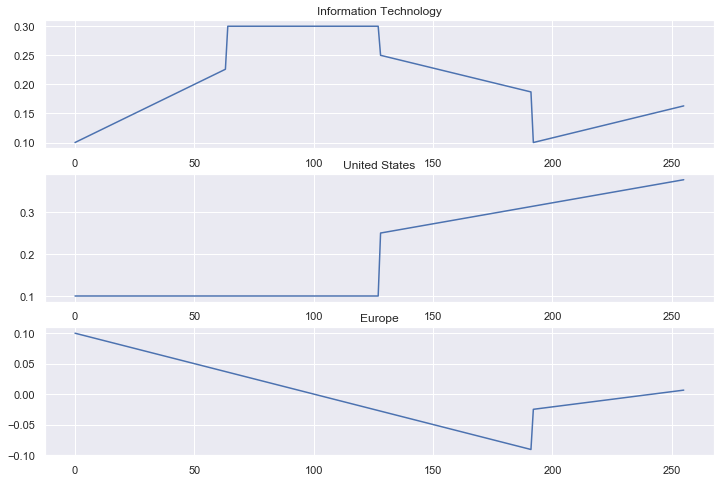

In [40]:
plot_many(3, 1, 12, 8, data=[
    [[[it.phi(t) for t in range(256)]]],
    [[[us.phi(t) for t in range(256)]]],
    [[[europe.phi(t) for t in range(256)]]],
], titles=["Information Technology", "United States", "Europe"]);

### Modelling Stocks
Stocks themselves have sentiment attached, and they have exposures to markets and segments on top. 

In [41]:
aapl_sentiments = {
    0: (.01, 0),         # start bullish for the first 90 days 
    64: (.05, .05/64),   # cool down a bit but recover well
    128: (-.03, .2/64),   # bad earnings, still recovering well
    192: (.04, 0),      # good sentiment
} 
ibm_sentiments = {
    0: (.02, 0),         # start bullish for the first 90 days 
    64: (.03, .05/64),   # cool down a bit but recover well
    128: (-.02, .02/64),   # bad earnings, still recovering well
    192: (.05, 0),      # good sentiment
} 

In [42]:
aapl = Stock(name='AAPL', psi0=100, E_cagr=1, max_effect=2.0,
             segments = {it: 1.0}, 
             markets={us: 0.5, europe: .3},
             sentiments=aapl_sentiments, noise=2.0)

ibm = Stock(name='IBM', psi0=110, E_cagr=.1, max_effect=2.0,
             segments = {it: 1.0}, 
             markets={us: 0.1, europe: .2},
             sentiments=ibm_sentiments, noise=2.0)

I have chosen a very large $\mathbb{E}(cagr)$ for AAPL to make the exponential growth in $\Psi(t)$ visible.

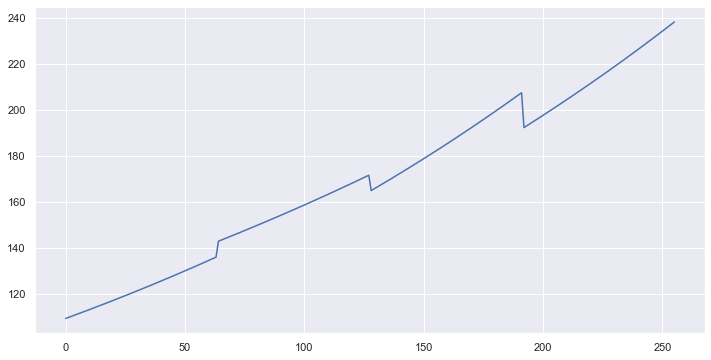

In [43]:
plt.plot([aapl.psi(t) for t in range(256)]);

### Modelling investors and the market